In [1]:
import torch
import torch.nn as nn
import torch.optim  as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils.utils import *
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

## first layers weight visualization

we choose alex net because its' first conv's filter size is 11x11, much big than common 3x3, so we can esaily find pattern here.

In [2]:
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

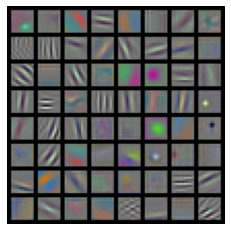

In [3]:
first_conv_weight = model.features[0].weight.data
plot_img_tensor(first_conv_weight)

## visualize high layers's filter

In [4]:
model = torchvision.models.vgg16(pretrained=True).features
for param in model.parameters():
    param.requires_grad = False
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [5]:
def lx_norm(input_data, alpha):
    return torch.sum(input_data ** alpha)

def TV_norm(input_data, beta):
    # x don not count the rightest and bottom pixel 
    x = input_data[..., :-1, :-1]
    
    y = input_data[..., 1:, :-1]
    z = input_data[..., :-1, 1:]
    return torch.sum(((y - x) ** 2 + (z - x) **2)**beta/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.457489013671875


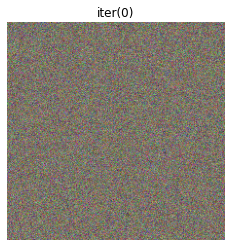

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.544747352600098


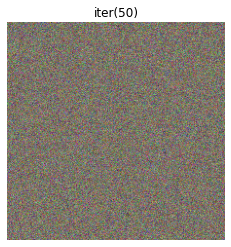

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.703794479370117


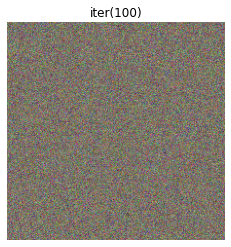

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.406106948852539


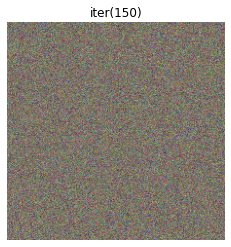

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.550890922546387


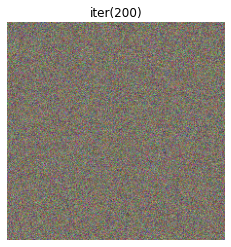

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.574187278747559


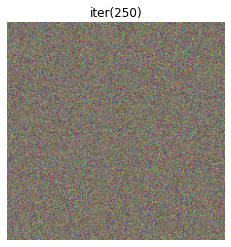

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.586946487426758


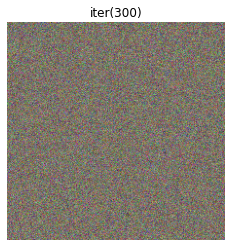

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: -12.575160026550293


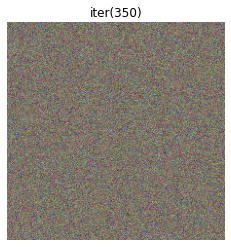

In [26]:
iter_num = 500
l_r = 1000
layer_choosed = 10
show_every = 50
filter_choosed = 7
jitter = 30

layers = model[:layer_choosed + 1].to(device)
# choose zores make it easier to see the pattern
# otherwise the init random noise may cover the pattern
noise = (torch.randn(1, 3, 224, 224)*0.1).requires_grad_(True)
optimizer = optim.Adam([noise], lr=l_r)

for iter in range(iter_num+1):
    noise = noise.to(device)
    o_x, o_y = int(torch.randint(low=-jitter, high=jitter, size=(1,))), int(torch.randint(low=-jitter, high=jitter, size=(1,)))
    noise = torch.roll(torch.roll(noise, o_x, 2), o_y, 3)

    layer_out = layers(noise)
    
    # we choose to maximize the mean of the selected filter
    loss = - torch.mean(layer_out[0, filter_choosed, ...] ** 2) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    noise = torch.roll(torch.roll(noise, -o_y, 3), -o_x, 2)
    
    # show res img
    if iter % show_every == 0:
            print(f"loss: {loss}")
            out = noise.cpu().clone().detach().squeeze(0)
            plt.imshow(deprocess(out).permute(1,2,0))
            plt.axis("off")
            plt.title(f"iter({iter})")
            plt.gcf().set_size_inches(4,4)
            plt.show()

torchvision.utils.save_image(noise, f"./imgs/outputs/1. layer_choosed [{layer_choosed}].png", normalize=True)

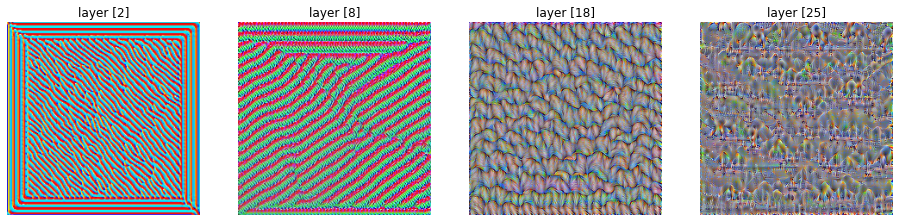

In [57]:
layer_num = [2, 8, 18, 25]
for i in range(len(layer_num)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(Image.open(f"./imgs/outputs/1. layer_choosed [{layer_num[i]}].png"))
    plt.title(f"layer [{layer_num[i]}]")
    plt.axis("off")
plt.gcf().set_size_inches((20, 60))
plt.show()